## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [57]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text

import xgboost as xgb


In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('../Data/New_York_City_Airbnb_Open_Data.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [5]:
# Create test and full training partitions 
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [6]:
# Create train and validation partitions 
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [7]:
# Verify the lenght of partitions 
len(df_train), len(df_val), len(df_test)

(29337, 9779, 9779)

In [9]:
# Reset indices of all partitions 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train_full = df_train_full.reset_index(drop=True)

In [11]:
# Extract target variable of all partitions 
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

In [12]:
# Delete target variable for all partitions 
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [13]:
# Create dictionaries of training data to apply one-hot enconding on categorical features 
train_dict = df_train.to_dict(orient='records')

In [14]:
# Create feature matrix with numerical and one-hot encoded categorical variables
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [15]:
# Create feature matrix of validation partition 
val_dict = df_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [19]:
dtreg = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)

print(export_text(dtreg, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* **`room_type`**
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

**Answer:** room_type was the feature used for splitting data 

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [21]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [28]:
rfreg = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1).fit(X_train, y_train)

y_pred = rfreg.predict(X_val)

print(f'RMSE RF regressor: {round(rmse(y_val, y_pred), 3)}')

RMSE RF regressor: 0.461


What's the RMSE of this model on validation?

* 0.059
* 0.259
* **0.459**
* 0.659

**Answer:** The RMSE of this model is 0.459

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [30]:
scores = []

for n in range(10, 201, 10):
    rfreg = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1).fit(X_train, y_train)

    y_pred = rfreg.predict(X_val)
    rmse_temp = round(rmse(y_val, y_pred), 3)
    
    scores.append((n, rmse_temp))

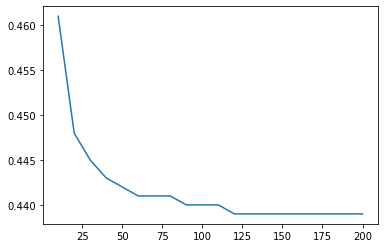

In [31]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

plt.plot(df_scores.n_estimators, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- **120**

**Answer:** The RMSE stopped to improve at n_stimators value of 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [35]:
scores2 = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rfreg = RandomForestRegressor(n_estimators=n, random_state=1,max_depth=d, n_jobs=-1).fit(X_train, y_train)

        y_pred = rfreg.predict(X_val)
        rmse_temp = round(rmse(y_val, y_pred), 3)
        
        scores2.append((d, n, rmse_temp))

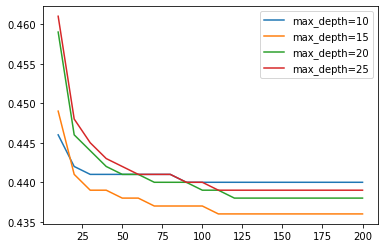

In [36]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores2 = pd.DataFrame(scores2, columns=columns)

for d in [10, 15, 20, 25]:
    df_subset = df_scores2[df_scores2.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

What's the best `max_depth`:

* 10
* **15**
* 20
* 25

**Answer:** The best max_depth is 15

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [52]:
feature_names = [f'feature {i}' for i in range(X_train.shape[1])]
rfreg2 = RandomForestRegressor(n_estimators=10, random_state=1, max_depth=20, n_jobs=-1).fit(X_train, y_train)

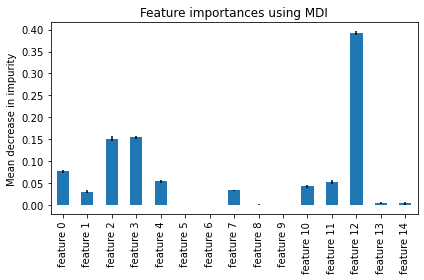

In [55]:
importances = rfreg2.feature_importances_

std = np.std([
    tree.feature_importances_ for tree in rfreg2.estimators_], axis=0)

rfreg2_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
rfreg2_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [56]:
dv.feature_names_

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* **`room_type=Entire home/apt`**	
* `longitude`
* `latitude`

**Answer:** The most important feature is room_type=Entire home/apt

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [85]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [58]:
# Create DMatrices
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [59]:
# Create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [86]:
# Empty dictionary to storage scores
scores = {}

In [87]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

xbg_model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [88]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
scores

{'eta=0.3':     num_iter  train_rmse  val_rmse
 0          0     3.02752   3.02415
 1          5     0.67490   0.67752
 2         10     0.43912   0.44981
 3         15     0.42259   0.43827
 4         20     0.41716   0.43691
 5         25     0.41365   0.43621
 6         30     0.40712   0.43543
 7         35     0.40444   0.43510
 8         40     0.40103   0.43466
 9         45     0.39723   0.43371
 10        50     0.39446   0.43384
 11        55     0.39129   0.43378
 12        60     0.38743   0.43404
 13        65     0.38421   0.43450
 14        70     0.38117   0.43467
 15        75     0.37801   0.43489
 16        80     0.37668   0.43526
 17        85     0.37259   0.43537
 18        90     0.36998   0.43539
 19        95     0.36742   0.43579
 20        99     0.36478   0.43621}

Now change `eta` first to `0.1` and then to `0.01`

In [89]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

xbg_model_eta_01 = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [90]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
scores

{'eta=0.3':     num_iter  train_rmse  val_rmse
 0          0     3.02752   3.02415
 1          5     0.67490   0.67752
 2         10     0.43912   0.44981
 3         15     0.42259   0.43827
 4         20     0.41716   0.43691
 5         25     0.41365   0.43621
 6         30     0.40712   0.43543
 7         35     0.40444   0.43510
 8         40     0.40103   0.43466
 9         45     0.39723   0.43371
 10        50     0.39446   0.43384
 11        55     0.39129   0.43378
 12        60     0.38743   0.43404
 13        65     0.38421   0.43450
 14        70     0.38117   0.43467
 15        75     0.37801   0.43489
 16        80     0.37668   0.43526
 17        85     0.37259   0.43537
 18        90     0.36998   0.43539
 19        95     0.36742   0.43579
 20        99     0.36478   0.43621,
 'eta=0.1':     num_iter  train_rmse  val_rmse
 0          0     3.87217   3.86889
 1          5     2.31905   2.31692
 2         10     1.41910   1.41786
 3         15     0.91299   0.91348
 4   

In [91]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

xbg_model_eta_001 = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [92]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
scores

{'eta=0.3':     num_iter  train_rmse  val_rmse
 0          0     3.02752   3.02415
 1          5     0.67490   0.67752
 2         10     0.43912   0.44981
 3         15     0.42259   0.43827
 4         20     0.41716   0.43691
 5         25     0.41365   0.43621
 6         30     0.40712   0.43543
 7         35     0.40444   0.43510
 8         40     0.40103   0.43466
 9         45     0.39723   0.43371
 10        50     0.39446   0.43384
 11        55     0.39129   0.43378
 12        60     0.38743   0.43404
 13        65     0.38421   0.43450
 14        70     0.38117   0.43467
 15        75     0.37801   0.43489
 16        80     0.37668   0.43526
 17        85     0.37259   0.43537
 18        90     0.36998   0.43539
 19        95     0.36742   0.43579
 20        99     0.36478   0.43621,
 'eta=0.1':     num_iter  train_rmse  val_rmse
 0          0     3.87217   3.86889
 1          5     2.31905   2.31692
 2         10     1.41910   1.41786
 3         15     0.91299   0.91348
 4   

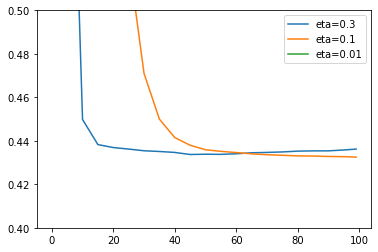

In [102]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.ylim(0.4, 0.5)
plt.legend()

What's the best eta?

* 0.3
* **0.1**
* 0.01

**Answer:** The best eta is 0.1

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

